# Fourier transforms of 1d and 2d signals

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, fft, ndimage, spatial
from sklearn.gaussian_process import kernels
from PIL import Image
import requests
from io import BytesIO

In [2]:
def make_signal(t):
    """Construct a cosine waveform for 1d examples."""
    xt = np.empty_like(t)
    w = 10 * (2 * np.pi)
    for n in range(6):
        xt += np.cos(n * w * t)
    return xt


def fft_spectrum(t, xt):
    """Decomposes into frequency components"""
    dt = t[1] - t[0]
    N = len(t)
    freq = fft.fftfreq(N, dt)
    xf = fft.fft(xt)
    return freq, xf


def make_checkerboard(grid_size):
    """Makes a checkerboard image in 2d."""
    im = np.zeros((grid_size, grid_size), dtype=np.uint8)
    im[::2, ::2] = 255
    im[1::2, 1::2] = 255
    return im


def make_lines(grid_size):
    """Make a line pattern in 2d."""
    im = np.zeros((grid_size, grid_size), dtype=np.uint8)
    for i in range(0, grid_size, 4):
        im[i] = 255
    return im


def fft2(img):
    """2D FFT"""
    f = fft.fft2(img)
    fshift = fft.fftshift(f)
    return np.log(1 + np.abs(fshift))


def plot(img, title=None):
    """Plot some images with their FFTs."""
    if title is None:
        title = "Patterned image"

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
    ax[0].imshow(img, cmap="gray")
    ax[0].set_title(title)
    ax[1].imshow(fft2(img), cmap="gray")
    ax[1].set_title("log FFT of " + title)
    plt.show()


def open_web_image(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }
    response = requests.get(url, headers=headers)
    img = Image.open(BytesIO(response.content))
    return img

This is a notebook demonstrating the Fourier transform in applications. The first
application will be a 1d problem and later applications will be 2d.

## 1d Example

Here we generate
$$
    x(t) = \sum_{n=1}^{5} \cos(20\pi n t)
$$
and then compute the FFT of $x(t)$.

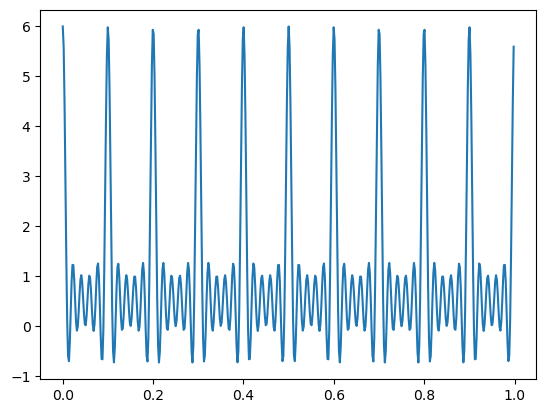

In [3]:
t = np.arange(0, 1, 1 / 512)
xt = make_signal(t)
plt.plot(t, xt)
plt.show()

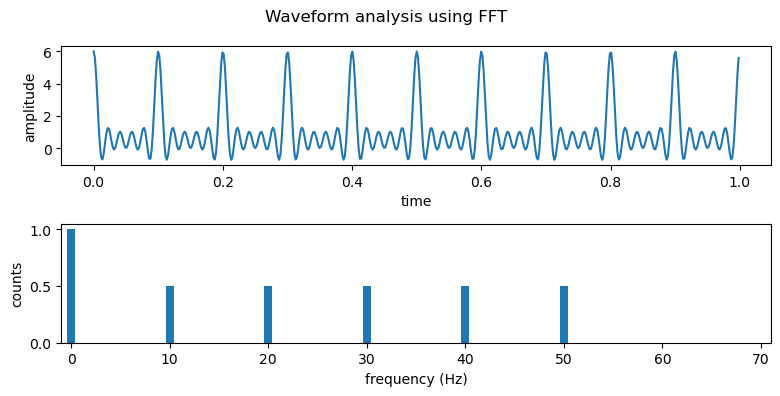

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4), tight_layout=True)
freq, st = fft_spectrum(t, xt)
ax[0].plot(t, xt, label="signal")
ax[0].set_xlabel("time")
ax[0].set_ylabel("amplitude")
ax[1].bar(freq, st.real / st.size, label="real")
ax[1].set_xlabel("frequency (Hz)")
ax[1].set_ylabel("counts")
ax[1].set_xlim(-1, 71)
fig.suptitle("Waveform analysis using FFT")
plt.show()

## 2d Examples

Next are 2d examples from images.

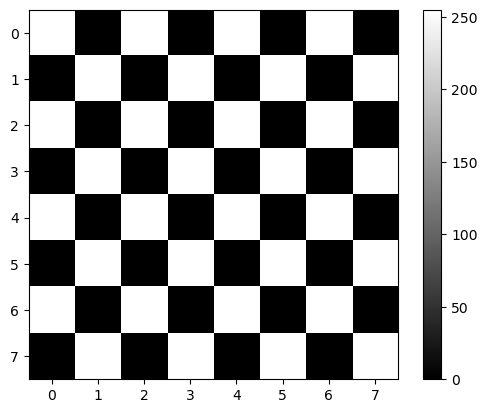

In [5]:
img = make_checkerboard(8)
plt.imshow(img, cmap="gray")
plt.colorbar()
plt.show()

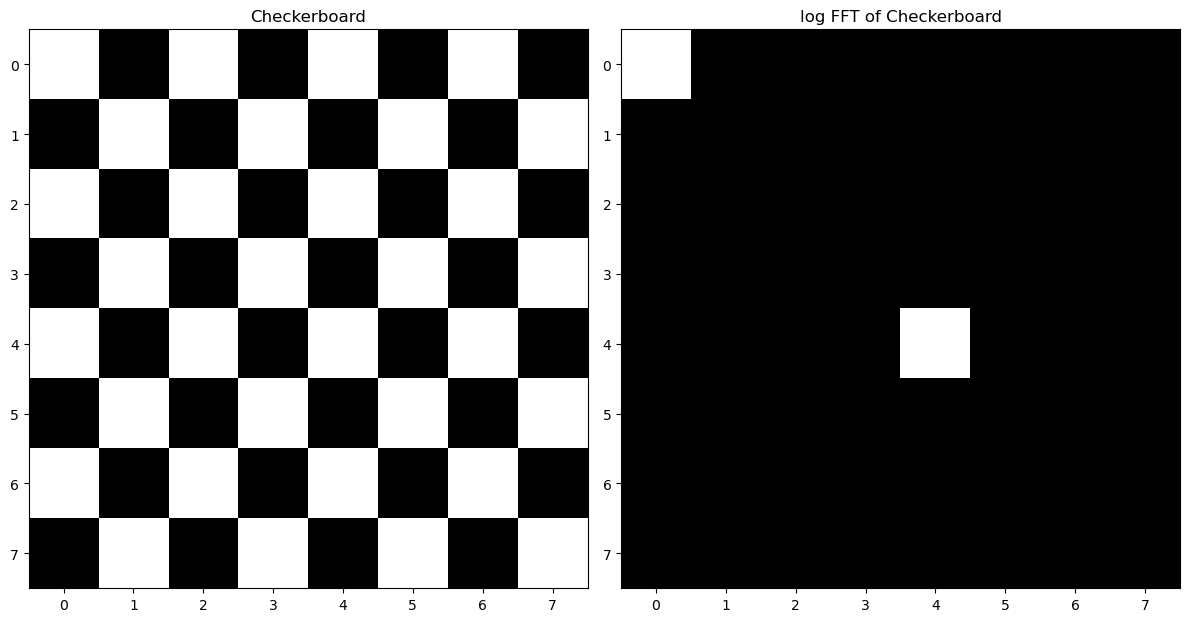

In [6]:
plot(img, "Checkerboard")

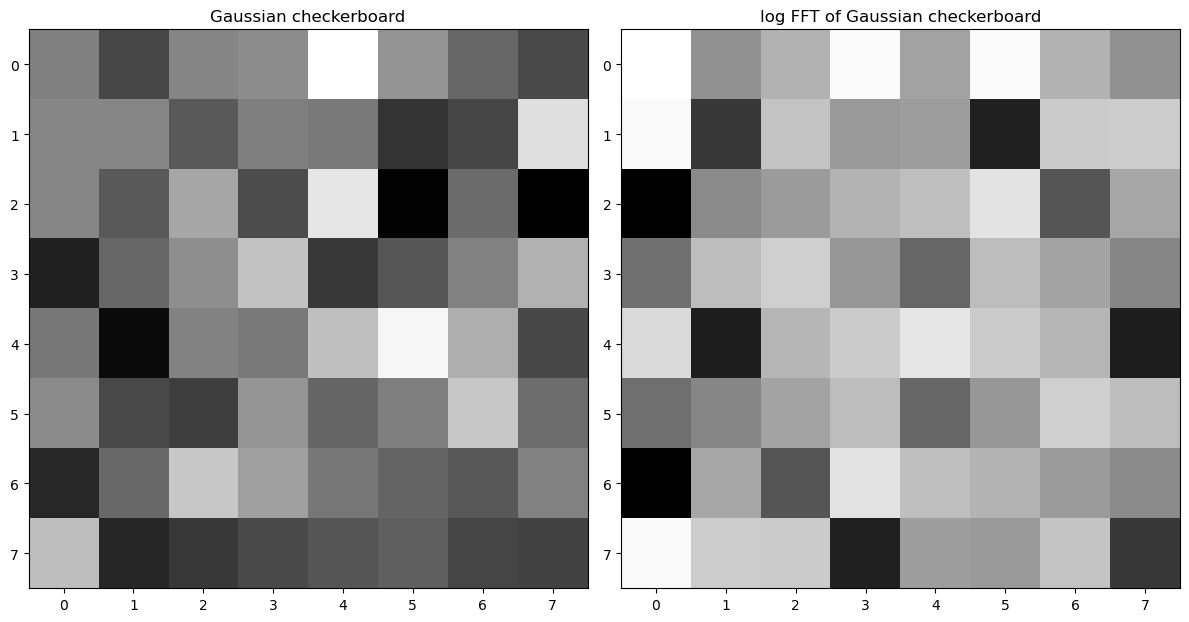

In [7]:
patterned_img = img + 500 * stats.norm(0, 1).rvs(img.shape)
plot(patterned_img, "Gaussian checkerboard")

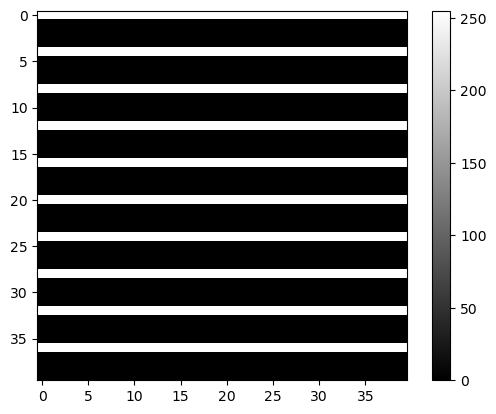

In [8]:
img = make_lines(40)
plt.imshow(img, cmap="gray")
plt.colorbar()
plt.show()

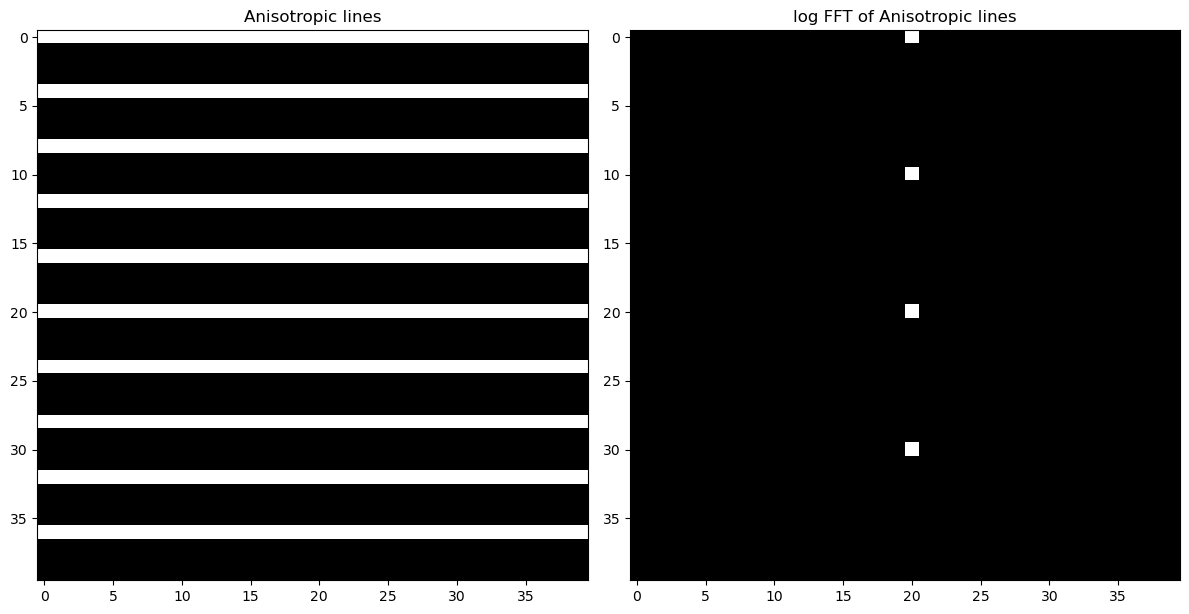

In [9]:
plot(img, "Anisotropic lines")

In [10]:
x = np.array(
    [
        np.repeat(np.linspace(0, 1, 30), 30),
        np.tile(np.linspace(0, 1, 30), 30),
    ]
).T
chol = np.linalg.cholesky(kernels.Matern(nu=1.5, length_scale=0.15)(x))

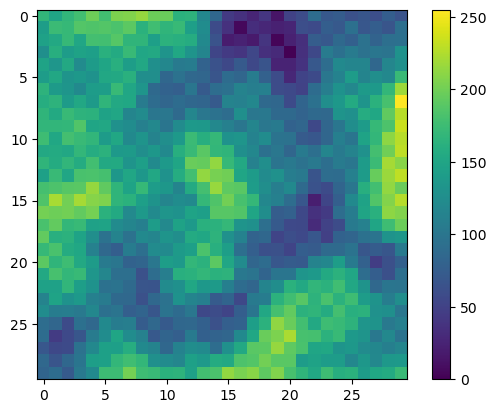

In [11]:
np.random.seed(42)
img = chol @ np.random.randn(900)
img = img.reshape(30, 30)
img += make_checkerboard(30) * 0.001
img = img - img.min()
img = img / img.max() * 255
img = img.astype(np.uint8)
plt.imshow(img)
plt.colorbar()
plt.show()

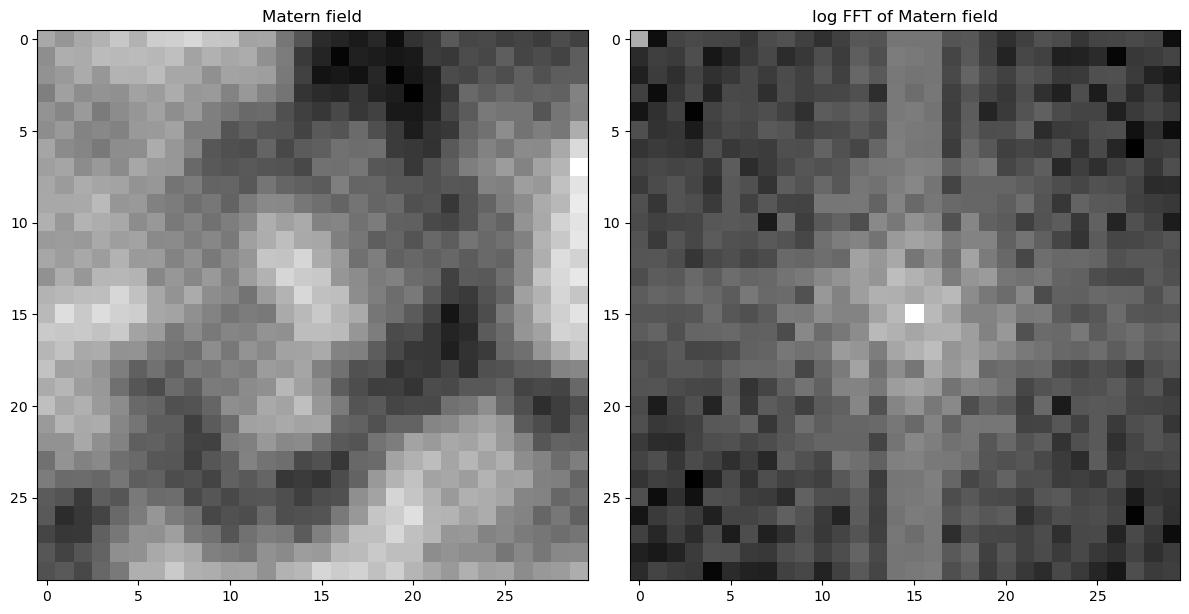

In [12]:
plot(img, "Matern field")

Next we'll load this image and compute its fft:

![stock_photo](https://www.noaa.gov/sites/default/files/styles/landscape_width_1275/public/legacy/image/2019/Jun/iStock-477110708%20(1).jpg)

In [13]:
url = "https://www.noaa.gov/sites/default/files/styles/landscape_width_1275/public/legacy/image/2019/Jun/iStock-477110708%20(1).jpg"

In [14]:
img = open_web_image(url)
img = np.asarray(img)
img.shape

(717, 1275, 3)

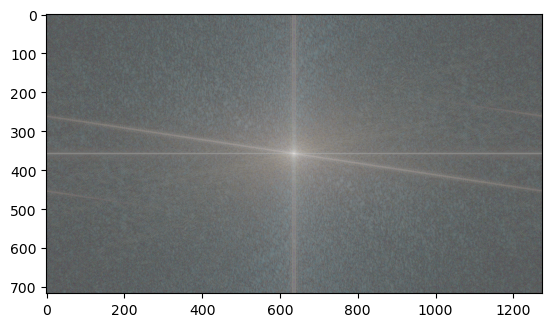

In [15]:
f = fft.fft2(img, axes=(0, 1))
fshift = fft.fftshift(f, axes=(0, 1))
magnitude_spectrum = np.log(1 + np.abs(fshift))
magnitude_spectrum = magnitude_spectrum / magnitude_spectrum.max()
plt.imshow(magnitude_spectrum)
plt.show()